In [1]:
! pip -q install transformers==2.9.0 gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 67.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.0 MB/s eta 0:00:00


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

logger = logging.getLogger(__name__)

MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [5]:
class Args():
    def __init__(self):
        self.output_dir = 'output'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium'
        self.config_name = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [6]:
import pandas as pd
df = pd.read_csv('cleaned_df.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()
trn_df, val_df = train_test_split(df, test_size = 0.2)
trn_df.head()

,context/9,context/8,context/7,context/6,context/5,context/4,context/3,context/2,context/1,context/0,context,response
2381,Or maybe there's someplace,for her in your bedroom?,There's nothing above your bed.,Are you still here?,"Oh, hi. Hello.",Have you come to ask me some more,paleontologyrelated questions?,"Your grandmother's nickname, perhaps?",AnnMargaret's pant size?,I've come here to apologize.,I think I may have let my feelings...,...for Charlie interfere
1024,"Well, we should go.",Yeah.,Ross?,Elizabeth!,Okay. I'm gonna go out this window.,I'll meet you at the front door.,"Just tell them you're going home, okay?",Okay.,"Wait, wait! No, don't go in there!",Don't go in there! I need another soda!,Ross!,"Oh, my God! What in heaven's name"
515,Would it?,"Hey, Tall Guy!",I want to talk to you about that girl,you're dancing with.,"She's nice, huh? To think I almost",brought my wife to this.,Yeah. Yeah. Okay.,"Look, I came with that girl, okay?",I plan to kiss her,at the New Year's countdown.,I'm trying to win her over. I,I don't think so.
219,I don't need a game room.,I only played those games because I,couldn't get girls. Now I can get,Now I have you.,"No, not that I think I have you. . .",. . .or think of you as property,in any sort of way. I see women. . . .,"Stop it, Chandler.",I'm sorry too.,Really?,"Yeah. Oh, yes.",We can think of something
811,That's right.,And what are you not gonna do?,I'm not gonna talk because,"Damn it, Carl!","Can I have the next one, please?",Thank you.,Joey and Tony Tribbiani.,That's us.,But this is a study,for identical twins.,That's right. $2000.,But you're not identical twins.


In [7]:
df = df.astype(str)

In [8]:
print(df.dtypes)

context/9    object
context/8    object
context/7    object
context/6    object
context/5    object
context/4    object
context/3    object
context/2    object
context/1    object
context/0    object
context      object
response     object
dtype: object


In [9]:
from collections import Counter
from statistics import mean, median, stdev
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [11]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

In [12]:
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

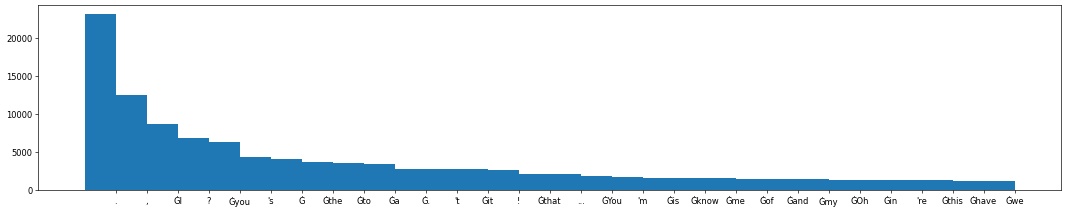

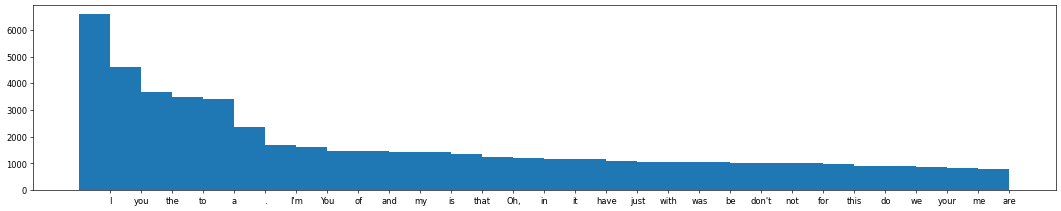

In [13]:
plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

In [14]:
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Mean: 80.62889518413597, Median: 80, Standard Deviation: 11.271068536928347, 90th Percentile: 154.0


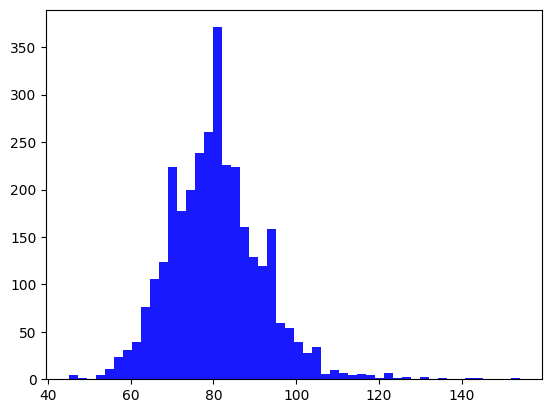

In [15]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens)

In [16]:
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        directory = args.cache_dir
        cached_features_file = os.path.join(
            directory, args.model_type + "_cached_lm_" + str(block_size)
        )

        if os.path.exists(cached_features_file) and not args.overwrite_cache:
            logger.info("Loading features from cached file %s", cached_features_file)
            with open(cached_features_file, "rb") as handle:
                self.examples = pickle.load(handle)
        else:
            logger.info("Creating features from dataset file at %s", directory)

            self.examples = []
            for _, row in df.iterrows():
                conv = construct_conv(row, tokenizer)
                if len(conv) > block_size: continue
                self.examples.append(conv)

            logger.info("Saving features into cached file %s", cached_features_file)
            with open(cached_features_file, "wb") as handle:
                pickle.dump(self.examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [17]:
def load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)


def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def _sorted_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> List[str]:
    ordering_and_checkpoint_path = []

    glob_checkpoints = glob.glob(os.path.join(args.output_dir, "{}-*".format(checkpoint_prefix)))

    for path in glob_checkpoints:
        if use_mtime:
            ordering_and_checkpoint_path.append((os.path.getmtime(path), path))
        else:
            regex_match = re.match(".*{}-([0-9]+)".format(checkpoint_prefix), path)
            if regex_match and regex_match.groups():
                ordering_and_checkpoint_path.append((int(regex_match.groups()[0]), path))

    checkpoints_sorted = sorted(ordering_and_checkpoint_path)
    checkpoints_sorted = [checkpoint[1] for checkpoint in checkpoints_sorted]
    return checkpoints_sorted


def _rotate_checkpoints(args, checkpoint_prefix="checkpoint", use_mtime=False) -> None:
    if not args.save_total_limit:
        return
    if args.save_total_limit <= 0:
        return

    checkpoints_sorted = _sorted_checkpoints(args, checkpoint_prefix, use_mtime)
    if len(checkpoints_sorted) <= args.save_total_limit:
        return

    number_of_checkpoints_to_delete = max(0, len(checkpoints_sorted) - args.save_total_limit)
    checkpoints_to_be_deleted = checkpoints_sorted[:number_of_checkpoints_to_delete]
    for checkpoint in checkpoints_to_be_deleted:
        logger.info("Deleting older checkpoint [{}] due to args.save_total_limit".format(checkpoint))
        shutil.rmtree(checkpoint)

In [18]:
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    model = model.module if hasattr(model, "module") else model  # Take care of distributed/parallel training
    model.resize_token_embeddings(len(tokenizer))

    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    if (
        args.model_name_or_path
        and os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt"))
        and os.path.isfile(os.path.join(args.model_name_or_path, "scheduler.pt"))
    ):

        optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
        scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
        )

    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        args.train_batch_size
        * args.gradient_accumulation_steps
        * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
    )
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    if args.model_name_or_path and os.path.exists(args.model_name_or_path):
        try:
            checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

            logger.info("  Continuing training from checkpoint, will skip to saved global_step")
            logger.info("  Continuing training from epoch %d", epochs_trained)
            logger.info("  Continuing training from global step %d", global_step)
            logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
        except ValueError:
            logger.info("  Starting fine-tuning.")

    tr_loss, logging_loss = 0.0, 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )
    set_seed(args)  
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  

            if args.n_gpu > 1:
                loss = loss.mean()  
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                scheduler.step()  
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    if (
                        args.local_rank == -1 and args.evaluate_during_training
                    ):  
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar("eval_{}".format(key), value, global_step)
                    tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    ) 
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(args, os.path.join(output_dir, "training_args.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    _rotate_checkpoints(args, checkpoint_prefix)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                    logger.info("Saving optimizer and scheduler states to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step


def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    eval_output_dir = args.output_dir

    eval_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )

    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [19]:
def main(df_trn, df_val):
    args = Args()
    
    if args.should_continue:
        sorted_checkpoints = _sorted_checkpoints(args)
        if len(sorted_checkpoints) == 0:
            raise ValueError("Used --should_continue but no checkpoint was found in --output_dir.")
        else:
            args.model_name_or_path = sorted_checkpoints[-1]

    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        args.local_rank,
        device,
        args.n_gpu,
        bool(args.local_rank != -1),
        args.fp16,
    )

    set_seed(args)

    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelWithLMHead.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)
    
    logger.info("Training/evaluation parameters %s", args)

    if args.do_train:
        train_dataset = load_and_cache_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

    if args.do_train:
        os.makedirs(args.output_dir, exist_ok=True)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        model_to_save = (
            model.module if hasattr(model, "module") else model
        ) 
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        model = AutoModelWithLMHead.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(
                os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
            )
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""

            model = AutoModelWithLMHead.from_pretrained(checkpoint)
            model.to(args.device)
            result = evaluate(args, model, tokenizer, df_trn, df_val, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

    return results

In [20]:
main(trn_df, val_df)

/usr/local/lib/python3.9/dist-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/794 [00:00<?, ?it/s]

Iteration:   0%|          | 0/794 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Iteration:   0%|          | 0/794 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/198 [00:00<?, ?it/s]

{'perplexity_': tensor(14.2654)}

In [50]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large")
model = AutoModelWithLMHead.from_pretrained('output')

for step in range(5):
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id, temperature=0.6, repetition_penalty=1.3)

    chat_history_ids = model.generate(
        bot_input_ids,
        do_sample=True, 
        max_length=1000,
        top_k=50, 
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )
    
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:hello!


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Hi.
>> User:Where are you?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I would like a massage.
>> User:By whom?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Hello?
>> User:Do you want to get a coffee?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Hi. Did we just become best friends?
>> User:I think so!


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Oh, my God!


In [41]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large")
model = AutoModelWithLMHead.from_pretrained('output')

for step in range(5):
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id, temperature=0.6, repetition_penalty=1.5)

    # generated a response while limiting the total chat history to 1000 tokens,
    # chat_history_ids = model.generate(
    #     bot_input_ids,
    #     do_sample=True, 
    #     max_length=1000,
    #     top_k=50, 
    #     top_p=0.95,
    #     pad_token_id=tokenizer.eos_token_id
    # )
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

/usr/local/lib/python3.9/dist-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


>> User:hello!


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Hi.
>> User:Who are you?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'm Rachel Green.
>> User:Where is Rachel?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Hi.
>> User:Do you want to party?


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'm sorry, I'm late.
>> User:Ok, see you!


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'll be right there.


In [24]:
model_save_name = 'medium.pt'
path = F"/content/drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [25]:
model_save_name = 'medium.pt'
path = F"/content/drive/{model_save_name}" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("#ok").click()
}
setInterval(ClickConnect,60000)